### Portfolio Optimization - Using ML, Scipy and Monte-Carlo to predict the best portfolio allocations

The objective of this project is to first obtain the best portfolio allocation given a set of assets (multi-assets classes). Thanks to yfinance, we can access the data on the value of all the assets under scrutiny. Then, we will create a correlation heatmap between the different classes of assets to have a visual understand of what diversification really is about. 

After that, we will follow Markowitz's methodlogy and use Scipy to obtain an optimized portfolio of assets under a set of constraints. 
Then, we will use Monte-Carlo simulation to have a broad idea of what performance portfolio allocations can deliver (and to make sure our portfolio obtained with scipy is really optimized).

After that, we will dive into ML with a random forest model. The objective is to predict volatility 5 days in the future (5 days after the last date we take into account for the previous calculus). This prediction of volatility will allow us to compute the optimized portfolio for 5 days in the future, following our predictions)

In [72]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import datetime
import yfinance as yf

#### Listing of assets under consideration

In [24]:
tickers = {
    'Actions Europe': ['MC.PA', 'SAP.DE', 'ASML.AS'],
    'Actions Amérique': ['AAPL', 'TSLA', 'JPM'],
    'Actions Asie': ['7203.T', '0700.HK', 'RELIANCE.NS'],
    'ETF': ['SPY', 'VGK', 'EWJ'],
    'Obligations': ['AGG', 'TLT'],
    'Commodities': ['GC=F', 'CL=F'],
    'Devises': ['EURUSD=X', 'USDJPY=X'],
    'Crypto': ['BTC-USD', 'ETH-USD']
}

rename_dict = {
    # Actions Europe
    'MC.PA': 'LVMH_France',
    'SAP.DE': 'SAP_Germany',
    'ASML.AS': 'ASML_Netherlands',
    'NESN.SW': 'Nestle_Switzerland',
    'VOD.L': 'Vodafone_UK',
    'SAN.MC': 'Santander_Spain',
    'ENI.MI': 'ENI_Italy',
    
    # Actions Amérique
    'AAPL': 'Apple_US',
    'TSLA': 'Tesla_US',
    'JPM': 'JPMorgan_US',
    'VALE': 'Vale_Brazil',
    'TD.TO': 'TD_Bank_Canada',

    
    # Actions Asie
    '7203.T': 'Toyota_Japan',
    'BABA': 'Alibaba_China',
    '005930.KS': 'Samsung_Korea',
    '0700.HK': 'Tencent_HongKong',
    'RELIANCE.NS': 'Reliance_India',
    
    # ETF et Indices Europe
    'EXSA.DE': 'ETF_Europe600',
    'VGK': 'ETF_FTSE_Europe',
    '^STOXX50E': 'Index_EuroStoxx50',
    
    # ETF et Indices Amérique
    'SPY': 'ETF_SP500',
    'QQQ': 'ETF_Nasdaq100',
    'EWZ': 'ETF_Brazil',
    
    # ETF et Indices Asie
    'EWJ': 'ETF_Japan',
    'MCHI': 'ETF_China',
    '^N225': 'Index_Nikkei225',
    '^HSI': 'Index_HangSeng',
    
    # Obligations
    'AGG': 'Bond_US_Aggregate',
    'TLT': 'Bond_Treasury_20Y',
    'LQD': 'Bond_InvestmentGrade',
    'HYG': 'Bond_HighYield',
    'VWOB': 'Bond_EmergingMarkets',
    
    # Matières premières

    'GC=F': 'Gold_Futures',
    'SI=F': 'Silver_Futures',
    'CL=F': 'Oil_WTI',
    'NG=F': 'NaturalGas_Futures',
    'HG=F': 'Copper_Futures',
    
    # Devises
    'EURUSD=X': 'FX_EUR_USD',
    'GBPUSD=X': 'FX_GBP_USD',
    'USDJPY=X': 'FX_USD_JPY',
    'AUDUSD=X': 'FX_AUD_USD',
    'USDCNY=X': 'FX_USD_CNY',
    
    # Cryptomonnaies
    'BTC-USD': 'Bitcoin',
    'ETH-USD': 'Ethereum',
    'BNB-USD': 'Binance',
    'ADA-USD': 'Cardano',
    'SOL-USD': 'Solana'
}


#### Computing log returns

Log returns are essential to compute volatility. It is the basis of calculation of historic volatility

In [25]:
all_tickers = [t for category in tickers.values() for t in category]
all_data = yf.download(all_tickers, start='2025-03-01', end ='2025-12-30')
all_data.dropna(inplace=True)
all_data = all_data.rename(columns=rename_dict)

log_returns = np.log(all_data['Close'] / all_data['Close'].shift(1))
log_returns.dropna(inplace=True)

#print(all_data.head(),"\n"*5,all_data.tail())
print(log_returns.head(),"\n"*5, log_returns.tail())

[*********************100%***********************]  20 of 20 completed

Ticker      Tencent_HongKong  Toyota_Japan  Apple_US  Bond_US_Aggregate  \
Date                                                                      
2025-03-04          0.016013     -0.014959 -0.008862          -0.002524   
2025-03-05          0.029104      0.034271 -0.000806          -0.003443   
2025-03-06          0.073401     -0.009521 -0.001741          -0.001015   
2025-03-07         -0.019490     -0.006933  0.015768          -0.001219   
2025-03-10         -0.032384      0.009233 -0.049694           0.004767   

Ticker      ASML_Netherlands   Bitcoin   Oil_WTI  Ethereum  FX_EUR_USD  \
Date                                                                     
2025-03-04         -0.044129  0.013348 -0.001610  0.011327    0.006813   
2025-03-05          0.018302  0.038255 -0.028983  0.032624    0.013448   
2025-03-06         -0.004022 -0.007330  0.000754 -0.017776    0.015680   
2025-03-07         -0.005988 -0.036438  0.010195 -0.029250   -0.000647   
2025-03-10         -0.041385 -

In [34]:
annual_ret = log_returns.mean() * 252
annual_vol = log_returns.std() * np.sqrt(252)
stats_df = pd.DataFrame({'Rendement Annuel': annual_ret, 'Vol Annuel': annual_vol}).round(3)
stats_df['Sharpe Ratio'] = (annual_ret - 0.02) / annual_vol
stats_df = stats_df.round(3).sort_values('Sharpe Ratio', ascending=False)
print(stats_df.head(10))

                  Rendement Annuel  Vol Annuel  Sharpe Ratio
Ticker                                                      
Gold_Futures                 0.568       0.238         2.298
FX_EUR_USD                   0.173       0.084         1.816
Reliance_India               0.396       0.213         1.769
ETF_FTSE_Europe              0.272       0.201         1.251
ETF_Japan                    0.286       0.222         1.200
JPMorgan_US                  0.328       0.261         1.176
ETF_SP500                    0.247       0.211         1.075
Tesla_US                     0.675       0.672         0.974
ASML_Netherlands             0.395       0.401         0.935
Tencent_HongKong             0.309       0.316         0.914


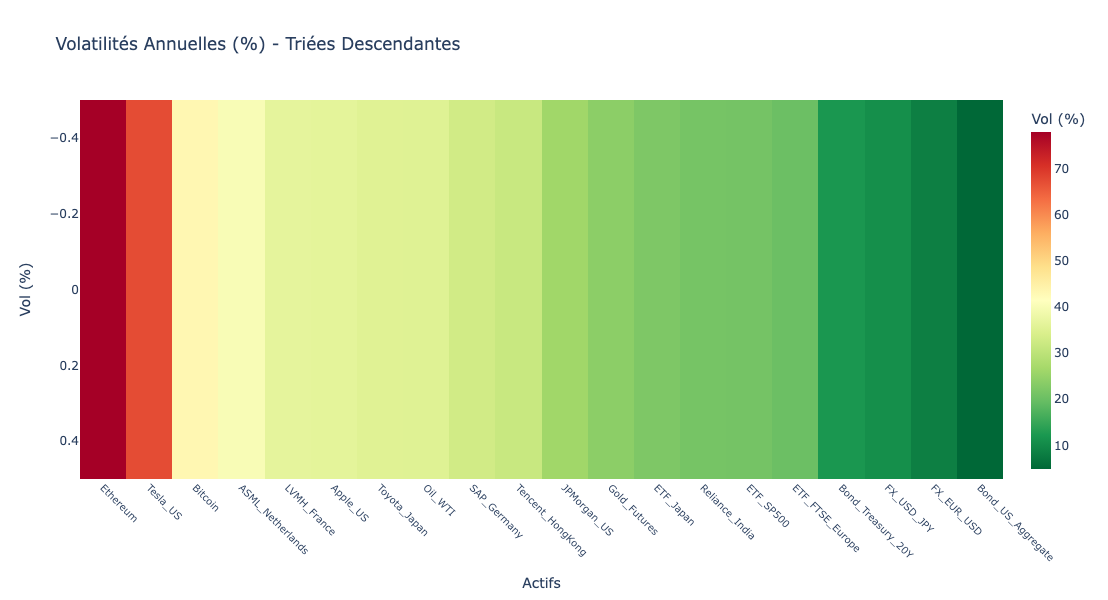

In [27]:
fig1 = px.imshow(annual_vol.sort_values(ascending=False).to_frame().T * 100,
                title="Volatilités Annuelles (%) - Triées Descendantes",
                color_continuous_scale='RdYlGn_r',  # Rouge=haute vol, Vert=basse
                aspect="auto",
                labels={'x': '', 'y': 'Vol (%)', 'color': 'Vol (%)'})

    
fig1.update_layout(height=600, xaxis_title="Actifs", 
                   coloraxis_colorbar=dict(title="Vol (%)", thickness=20))
fig1.update_xaxes(tickangle=45, tickfont=dict(size=10))
fig1.show()

#### Correlation  Heatmap

The objective is to analyse the correlation between the differetns classes of assets to have a good qualtitative analysis on what diversification represents

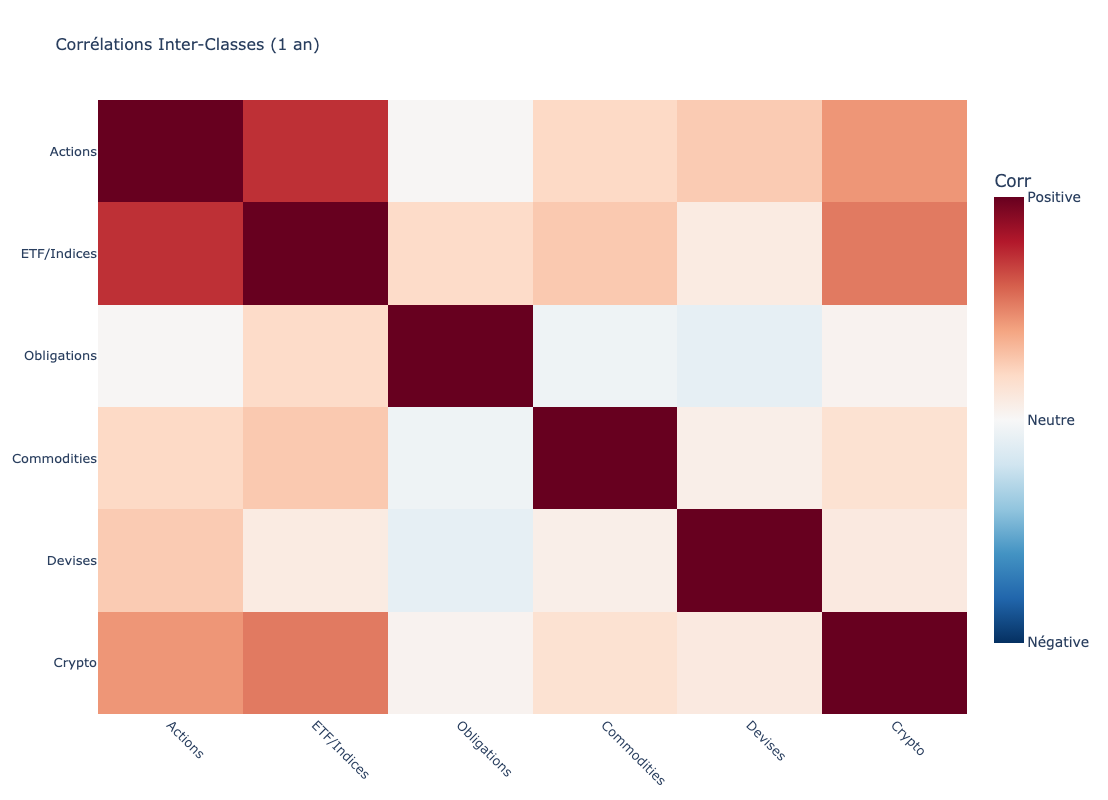

In [28]:
# Définir groupes (basé sur tes tickers)
groupes = {
    "Actions" : [
    'LVMH_France',
    'SAP_Germany',
    'ASML_Netherlands',
    'Nestle_Switzerland',
    'Vodafone_UK',
    'Santander_Spain',
    'ENI_Italy',
    
    # Actions Amérique
    'Apple_US',
    'Tesla_US',
    'JPMorgan_US',
    'Vale_Brazil',
    'TD_Bank_Canada',

    
    # Actions Asie
    'Toyota_Japan',
    'Alibaba_China',
    'Samsung_Korea',
    'Tencent_HongKong',
    'Reliance_India'],
    
    # ETF et Indices Europe
    "ETF/Indices" : [
    'ETF_Europe600',
 
   'ETF_FTSE_Europe',
    'Index_EuroStoxx50',
    
    # ETF et Indices Amérique
    'ETF_SP500',
    'ETF_Nasdaq100',
    'ETF_Brazil',
    
    # ETF et Indices Asie
    'ETF_Japan',
    'ETF_China',
    'Index_Nikkei225',
    'Index_HangSeng'],
    
    # Obligations
    "Obligations" : [
    'Bond_US_Aggregate',
    'Bond_Treasury_20Y',
    'Bond_InvestmentGrade',
    'Bond_HighYield',
    'Bond_EmergingMarkets'],
    
    # Matières premières

    "Commodities" : [
    'Gold_Futures',
    'Silver_Futures',
    'Oil_WTI',
    'NaturalGas_Futures',
    'Copper_Futures'],
    
    # Devises
    "Devises" : [
    'FX_EUR_USD',
    'FX_GBP_USD',
    'FX_USD_JPY',
    'FX_AUD_USD',
    'FX_USD_CNY'],
    
    # Cryptomonnaies
    "Crypto" : [
    'Bitcoin',
    'Ethereum',
    'Binance',
    'Cardano',
    'Solana']
}


# Corrélations entre groupes (échantillon récent)
recent_returns = log_returns.iloc[-252:]  # 1 an
group_returns = pd.DataFrame(index=recent_returns.index)
for g_name, g_tickers in groupes.items():
    valid_tickers = [t for t in g_tickers if t in log_returns.columns]
    group_returns[g_name] = log_returns[valid_tickers].mean(axis=1)

corr_matrix = group_returns.corr()
fig = px.imshow(
    corr_matrix,
    title="Corrélations Inter-Classes (1 an)",
    color_continuous_scale="RdBu_r",
    zmin=-1, zmax=1,
    aspect="square",  # Carré parfait
    labels=dict(color="Corrélation")
)

# ZOOM & TYPO PERSONNALISÉS
fig.update_layout(
    height=800,  # +200px hauteur (6-7 groupes)
    width=900,   # Largeur adaptée
    font=dict(size=14),  # Texte +grand
    title_font_size=16
)

# Labels axes lisibles
fig.update_xaxes(tickangle=45, tickfont=dict(size=13))
fig.update_yaxes(tickfont=dict(size=13))

# Colorbar affinée
fig.update_layout(coloraxis_colorbar=dict(
    thickness=30,      # +large
    len=0.8,           # Longueur
    title="Corr",      # Court
    ,
    tickvals=[-1, 0, 1],
    ticktext=["Négative", "Neutre", "Positive"]
))

fig.show()



#### Markowitz Portfolio Optimization with Scipy

In [37]:
def neg_sharpe_ratio(weights, returns, risk_free_rate=0.02):
    #Objectif : MAX Sharpe = Rendement / Vol (neg pour minimize)
    port_return = np.sum(returns.mean() * weights) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return -(port_return - risk_free_rate) / port_vol

def optimiser_markowitz(returns_selected, max_poids=0.20):
    #Optimise portefeuille max Sharpe
    n_assets = returns_selected.shape[1]
    bounds = tuple((0, max_poids) for _ in range(n_assets))
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    
    # Guess initial : égal
    init_guess = np.array([1/n_assets] * n_assets)
    
    result = minimize(neg_sharpe_ratio, init_guess, 
                     args=(returns_selected,),
                     method='SLSQP', bounds=bounds, constraints=constraints)
    
    if result.success:
        return result.x
    else:
        print("Optimisation échouée, poids égaux")
        return init_guess

def portfolio_performance(weights, returns):
    port_return = np.sum(returns.mean() * weights) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return port_return, port_vol



Optim sur : ['Gold_Futures', 'FX_EUR_USD', 'Reliance_India', 'ETF_FTSE_Europe', 'ETF_Japan', 'JPMorgan_US', 'ETF_SP500', 'Tesla_US', 'ASML_Netherlands', 'Tencent_HongKong', 'Bond_US_Aggregate', 'Toyota_Japan', 'Ethereum', 'Apple_US', 'FX_USD_JPY']
Portefeuille Optimal : Ret 24.3% | Vol 6.5% | Sharpe 3.45


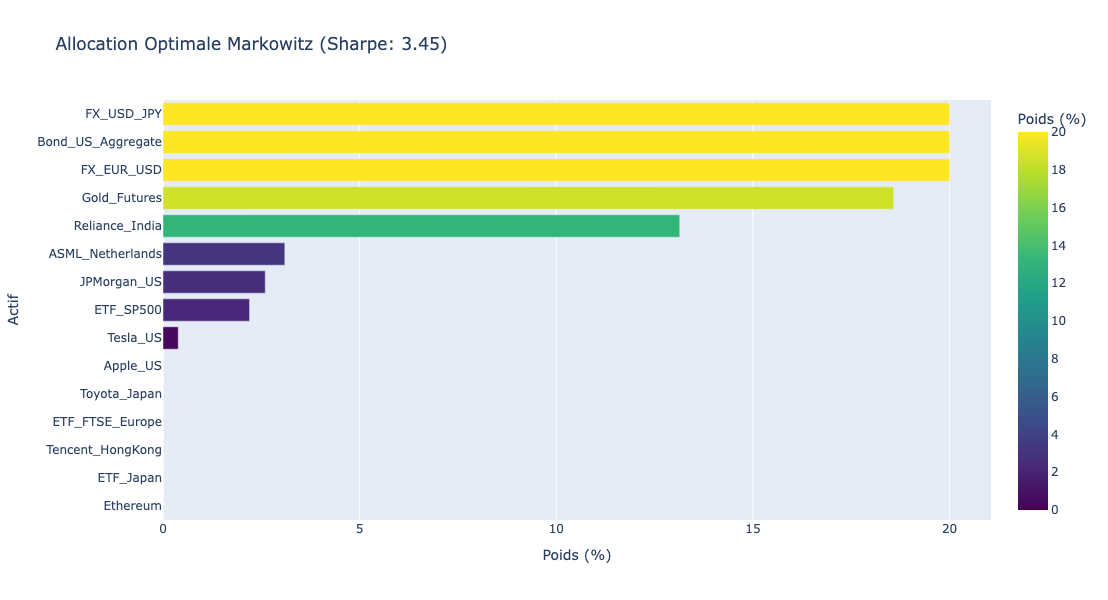

In [38]:
# 1. Sélectionne 10-15 meilleurs actifs
top_actifs = stats_df.nlargest(15, 'Sharpe Ratio').index.tolist()
print("Optim sur :", top_actifs)

# 2. Optimisation
poids_optimaux = optimiser_markowitz(log_returns[top_actifs])

# 3. Performances
ret_opt, vol_opt = portfolio_performance(poids_optimaux, log_returns[top_actifs])
sharpe_opt = (ret_opt - 0.02) / vol_opt
print(f"Portefeuille Optimal : Ret {ret_opt:.1%} | Vol {vol_opt:.1%} | Sharpe {sharpe_opt:.2f}")

# 4. Visualisation Poids (Bar interactif)
poids_df = pd.DataFrame({
    'Actif': top_actifs,
    'Poids (%)': poids_optimaux * 100
}).sort_values('Poids (%)', ascending=True)

fig = px.bar(poids_df, y='Actif', x='Poids (%)', 
             orientation='h',
             title=f"Allocation Optimale Markowitz (Sharpe: {sharpe_opt:.2f})",
             color='Poids (%)', color_continuous_scale='Viridis')
fig.update_layout(height=600)
fig.show()


### Monte Carlo Simulations

The objective is to simulate 10 000 different portfolio allocations to make sure that our optimal calculus made with scipy is good
We will be ploting the Return = f(Volatility) curve and make sure there is no random portfolio allocation that beats the sharpe ratio we got right before

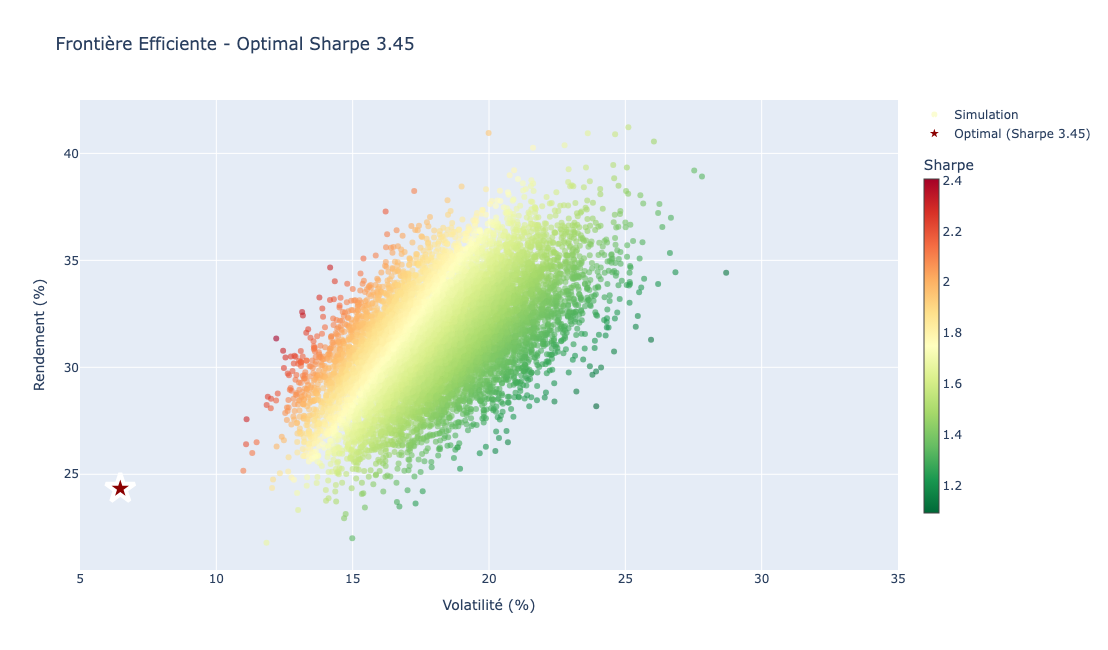

In [89]:
# Monte Carlo (inchangé)
n_sim = 10000
results = np.zeros((3, n_sim))
np.random.seed(420)
for i in range(n_sim):
    weights = np.random.random(len(top_actifs))
    weights /= np.sum(weights)
    ret, vol = portfolio_performance(weights, log_returns[top_actifs])
    results[0,i] = ret
    results[1,i] = vol
    results[2,i] = (ret - 0.02) / vol

ret_opt, vol_opt = portfolio_performance(poids_optimaux, log_returns[top_actifs])
sharpe_opt = (ret_opt - 0.02) / vol_opt

# Visualisation SANS TEXTE FIXE
fig = go.Figure()

# Nuage
fig.add_trace(go.Scatter(
    x=results[1,:]*100, y=results[0,:]*100,
    mode='markers',
    marker=dict(size=6, opacity=0.6, color=results[2,:], 
                colorscale='RdYlGn_r',
                colorbar=dict(title="Sharpe", 
                              thickness=15,      # ← Plus fine (de 25→15)
                              len=0.8,           # ← Plus courte (de 0.8→0.6)
                              y=0.5,)),
    hovertemplate="<b>Simu Monte Carlo</b><br>" +
                  "Vol: %{x:.1f}%<br>" +
                  "Rendement: %{y:.1f}%<br>" +
                  "<b>Sharpe: %{marker.color:.2f}</b><extra></extra>",
    
    name="Simulation"
))

# ÉTOILE UNIQUEMENT (hover auto)
fig.add_trace(go.Scatter(
    x=[vol_opt*100], y=[ret_opt*100],
    mode='markers',
    marker=dict(size=22, color='darkred', symbol='star', 
                line=dict(color='white', width=4)),
    name=f"Optimal (Sharpe {sharpe_opt:.2f})",
    hovertemplate="<b> OPTIMAL MARKOWITZ</b><br>" +
                  "Sharpe: %{text:.2f}<br>Vol: %{x:.1f}%<br>Ret: %{y:.1f}%<extra></extra>",
    text=[sharpe_opt]
))


fig.update_layout(
    title=f"Frontière Efficiente - Optimal Sharpe {sharpe_opt:.2f}",
    xaxis_title="Volatilité (%)", xaxis_range=[5, 35],
    yaxis_title="Rendement (%)",
    height=650, showlegend=True,
    hovermode="closest"
)
fig.show()


### BackTest - Comparison with S&P 500

Let's compare our portfolio's performance with that of the S&P500

BACKTEST 2025-03-04 → 2025-12-29
Optimal: +18.7% | Vol 6.5% | Sharpe 3.45
SPY: +17.4%


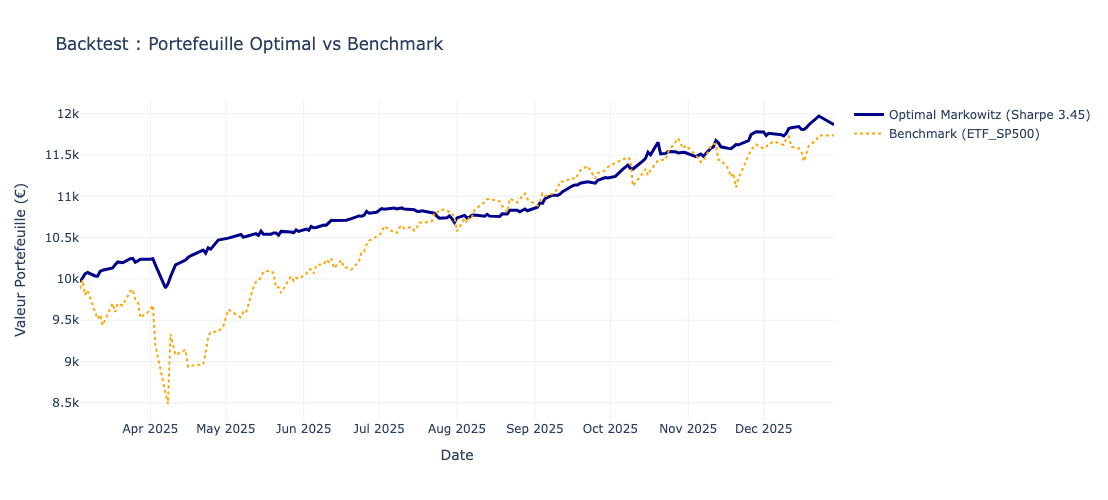

In [71]:
# 1. Rendements portefeuille optimal (période totale)
rendements_opt = (log_returns[top_actifs] * poids_optimaux).sum(axis=1)
equity_opt = (1 + rendements_opt).cumprod() * 10000  # 10k€ départ

# 2. Benchmark SPY
spy_col = 'ETF_SP500' if 'ETF_SP500' in log_returns else 'SPY'
if spy_col in log_returns.columns:
    equity_spy = (1 + log_returns[spy_col]).cumprod() * 10000


# 3. Métriques
total_ret_opt = equity_opt.iloc[-1] / 10000 - 1
vol_opt = rendements_opt.std() * np.sqrt(252)
sharpe_final = (rendements_opt.mean() * 252 - 0.02) / vol_opt

print(f"BACKTEST {log_returns.index[0].date()} → {log_returns.index[-1].date()}")
print(f"Optimal: +{total_ret_opt:.1%} | Vol {vol_opt:.1%} | Sharpe {sharpe_final:.2f}")
print(f"{'SPY' if spy_col != 'ETFSP500' else 'ETFSP500'}: +{(equity_spy.iloc[-1]/10000-1):.1%}")

# 4. Visualisation Equity Curves
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=log_returns.index, y=equity_opt,
    line=dict(color='darkblue', width=3),
    name=f"Optimal Markowitz (Sharpe {sharpe_final:.2f})"
))

fig.add_trace(go.Scatter(
    x=log_returns.index, y=equity_spy,
    line=dict(color='orange', width=2, dash='dot'),
    name=f"Benchmark ({spy_col})"
))

fig.update_layout(
    title="Backtest : Portefeuille Optimal vs Benchmark",
    xaxis_title="Date", yaxis_title="Valeur Portefeuille (€)",
    height=500, showlegend=True,
    template='plotly_white'
)
fig.show()


### Using ML to predict future returns

 Prédiction volatilité 5j par actif...

 VOLATILITÉS PRÉDITES 5j (Top/Bottom 5):
                   Vol_pred_5j
Bond_US_Aggregate     0.032324
FX_EUR_USD            0.039844
ETF_FTSE_Europe       0.050818
ETF_SP500             0.076109
ETF_Japan             0.080313
                  Vol_pred_5j
Tencent_HongKong     0.208409
Toyota_Japan         0.232749
Gold_Futures         0.275486
Ethereum             0.438945
Tesla_US             0.553762

 Optimisation Minimum Variance (vol prédites)...

 PORTFEUILLE PRÉDIT Minimum Variance:
  Rendement espéré: 33.4%
  Volatilité prédite 5j: 3.5%
  Sharpe: 8.87

 Allocation Top 5:
  Gold_Futures: 20.0%
  FX_EUR_USD: 20.0%
  Reliance_India: 20.0%
  ETF_FTSE_Europe: 12.2%
  ETF_Japan: 13.1%


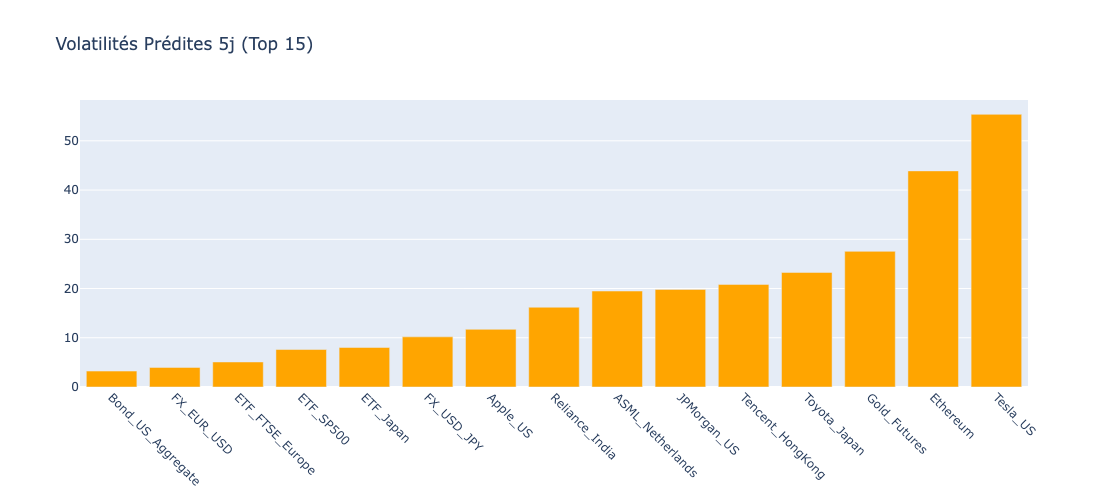

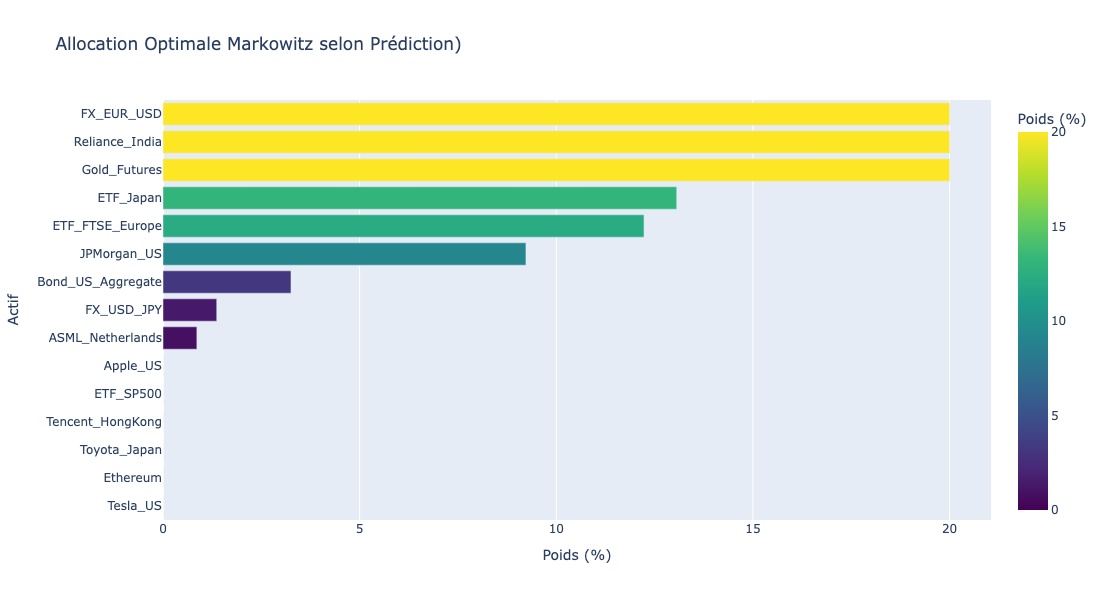

In [88]:
print(" Prédiction volatilité 5j par actif...")

# 1. Fonction features VOL (EWMA + lags)
def features_vol(returns, actif, window=5):
    #Features pour prédire vol 5j d'un actif
    ret_actif = returns[actif] #Récupère rendements de 1 actif (ex: ETF_SP500) 
                               # Série: [0.01, -0.02, 0.03, ...]
                               # Index: dates (2025-03-04, 2025-03-05...)
    
    df = pd.DataFrame(index=ret_actif.index) #df.shape = (200 jours, 0 colonnes)
    df['ret'] = ret_actif # Maintenant df: ['ret'] = [0.01, -0.02, 0.03...]
    
    # Lags rendements
    for i in range(1, 6):
        df[f'lag_ret_{i}'] = ret_actif.shift(i) #shift(i) = "Décaler i jours ARRIÈRE"
    
    # Vol EWMA (span=10)
    df['vol_ewma'] = ret_actif.ewm(span=10).std() #Décroissance expo du poids de chaque jour dans le calcul avec demi-vie (span) de 10 jours
    
    # Vol roulante 20j
    df['vol_20'] = ret_actif.rolling(20).std() #On considère les 20 derniers jours, chaque jour ayant un poids égal
    
    # Momentum 5j
    df['mom_5'] = ret_actif.rolling(5).mean()
    
    # Target : VOL 5j future (annualisée)
    df['vol_target'] = ret_actif.rolling(5).std() * np.sqrt(252)
    df = df.dropna()
    
    return df

# 2. Prédictions par actif
vol_pred_5j = {}
for actif in top_actifs:
    feat = features_vol(log_returns, actif)
    X = feat[['lag_ret_1','lag_ret_2','vol_ewma','vol_20','mom_5']]
    y = feat['vol_target']

    rf = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=5) #Modèle random forest pour prédire la vol
    rf.fit(X, y) #On fit le modèle avec les données que l'on a 
    
    dernier_X = X.tail(1)
    vol_pred_5j[actif] = rf.predict(dernier_X)[0]

# 3. DataFrame volatilités prédites
vol_pred_df = pd.DataFrame({'Vol_pred_5j': vol_pred_5j}, index=top_actifs) #prediction sous forme de df
vol_pred_df = vol_pred_df.sort_values('Vol_pred_5j', ascending=True) #on trie les valeurs

print("\n VOLATILITÉS PRÉDITES 5j (Top/Bottom 5):")
print(vol_pred_df.head())
print(vol_pred_df.tail())

# 4. MARKOWITZ MINIMUM VARIANCE sur prédictions vol
print("\n Optimisation Minimum Variance (vol prédites)...")

# Rendements historiques (moyennes)
rend_hist = log_returns[top_actifs].mean() * 252

# Matrice corrélations
corr_ml = log_returns[top_actifs].corr()

def neg_vol_pred(w, vol_pred, corr):
    vol_port = np.sqrt(np.dot(w.T, np.dot(np.diag(vol_pred) @ corr @ np.diag(vol_pred), w)))
    return vol_port
# w = poids
# vol_pred = vols prédites
# corr = corrélations
# Matrice_var = Transpose(Weights) * Matrice_covar * Weights


def min_variance_vol_pred(vol_pred_array, corr_matrix, max_poids=0.20):
    n = len(vol_pred_array) #n est le nombre de variables de décision
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) #contraintes
    bnds = tuple((0, max_poids) for _ in range(n))
    
    res = minimize(neg_vol_pred, np.ones(n)/n, args=(vol_pred_array, corr_ml),
                   method='SLSQP', bounds=bnds, constraints=cons) #Calcul d'optimisation
    
    return res.x 

# Optimisation
poids_minvar = min_variance_vol_pred(vol_pred_df['Vol_pred_5j'].values, corr_ml)
rendements_historiques = log_returns[top_actifs].mean() * 252

# Calcul performance directe
ret_minvar = np.sum(rendements_historiques * poids_minvar) 
vol_minvar = np.sqrt(np.dot(poids_minvar.T, 
                          np.dot(np.diag(vol_pred_df['Vol_pred_5j'].values) @ corr_ml @ np.diag(vol_pred_df['Vol_pred_5j'].values), 
                                 poids_minvar)))

sharpe_minvar = (ret_minvar - 0.02) / vol_minvar if vol_minvar > 0 else 0

print(f"\n PORTFEUILLE PRÉDIT Minimum Variance:")
print(f"  Rendement espéré: {ret_minvar:.1%}")
print(f"  Volatilité prédite 5j: {vol_minvar:.1%}")
print(f"  Sharpe: {sharpe_minvar:.2f}")
print(f"\n Allocation Top 5:")
for i, (actif, poids) in enumerate(zip(top_actifs, poids_minvar)):
    if i < 5:
        print(f"  {actif}: {poids:.1%}")

# 5. Graph
fig = go.Figure()
fig.add_trace(go.Bar(x=vol_pred_df.index[:15], y=vol_pred_df['Vol_pred_5j'][:15]*100,
                     name="Vol Prédite 5j (%)", marker_color='orange'))
fig.update_layout(title="Volatilités Prédites 5j (Top 15)", 
                  xaxis_tickangle=45, height=500)

#df des poids de chaque actif pour pouvoir ploter
poids_df = pd.DataFrame({
    'Actif': top_actifs,
    'Poids (%)': poids_minvar * 100
}).sort_values('Poids (%)', ascending=True)

fig2 = px.bar(poids_df, y='Actif', x='Poids (%)', 
             orientation='h',
             title=f"Allocation Optimale Markowitz selon Prédiction)",
             color='Poids (%)', color_continuous_scale='Viridis')
fig2.update_layout(height=600)

fig.show()
fig2.show()